In [2]:
import numpy as np
import pylidc as pl
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import pydicom
import pandas as pd 
import seaborn as sns
import pickle
from PIL import Image
from tqdm import tqdm
from pylidc.utils import consensus
from scipy.stats import entropy
from skimage.measure import find_contours

In [2]:
scans = pl.query(pl.Scan).all()

In [3]:
df = pd.read_excel('tcia-diagnosis-data-2012-04-20.xls')
print(df.head())

  TCIA Patient ID  \
0  LIDC-IDRI-0068   
1  LIDC-IDRI-0071   
2  LIDC-IDRI-0072   
3  LIDC-IDRI-0088   
4  LIDC-IDRI-0090   

   Diagnosis at the Patient Level\n0=Unknown\n1=benign or non-malignant disease\n2= malignant, primary lung cancer\n3 = malignant metastatic\n  \
0                                                  3                                                                                             
1                                                  3                                                                                             
2                                                  2                                                                                             
3                                                  3                                                                                             
4                                                  2                                                                                           

In [4]:
nodule_diagnosis={}
for i in range(len(df)):
    id = df.loc[i, 'TCIA Patient ID']
    nodule1 = df.loc[i, 'Nodule 1 Diagnosis']
    nodule2 = df.loc[i, 'Nodule 2 Diagnosis']
    if nodule1==1.0 :
        nodule_diagnosis[id]=[0]
    elif nodule1==2.0 or nodule1==3.0 :
        nodule_diagnosis[id]=[1]
    if nodule2==1.0 :
        nodule_diagnosis[id].append(0)
    elif nodule2==2.0 or nodule2==3.0 :
        nodule_diagnosis[id].append(1)
print(nodule_diagnosis)

{'LIDC-IDRI-0068': [1], 'LIDC-IDRI-0071': [0], 'LIDC-IDRI-0072': [0], 'LIDC-IDRI-0090': [1], 'LIDC-IDRI-0091': [1], 'LIDC-IDRI-0100': [0], 'LIDC-IDRI-0124': [1], 'LIDC-IDRI-0129': [1], 'LIDC-IDRI-0135': [1], 'LIDC-IDRI-0137': [1], 'LIDC-IDRI-0138': [1], 'LIDC-IDRI-0149': [0], 'LIDC-IDRI-0159': [1], 'LIDC-IDRI-0161': [1], 'LIDC-IDRI-0162': [0], 'LIDC-IDRI-0163': [1], 'LIDC-IDRI-0164': [1], 'LIDC-IDRI-0165': [1], 'LIDC-IDRI-0166': [1], 'LIDC-IDRI-0167': [0], 'LIDC-IDRI-0168': [0], 'LIDC-IDRI-0169': [1], 'LIDC-IDRI-0171': [0, 0], 'LIDC-IDRI-0174': [1, 1], 'LIDC-IDRI-0175': [1], 'LIDC-IDRI-0178': [0], 'LIDC-IDRI-0179': [1], 'LIDC-IDRI-0180': [0], 'LIDC-IDRI-0181': [1], 'LIDC-IDRI-0182': [1], 'LIDC-IDRI-0183': [0], 'LIDC-IDRI-0184': [1], 'LIDC-IDRI-0185': [0], 'LIDC-IDRI-0186': [1], 'LIDC-IDRI-0187': [0], 'LIDC-IDRI-0188': [1], 'LIDC-IDRI-0189': [1], 'LIDC-IDRI-0190': [1, 0], 'LIDC-IDRI-0191': [1], 'LIDC-IDRI-0192': [1], 'LIDC-IDRI-0193': [1], 'LIDC-IDRI-0194': [1, 1], 'LIDC-IDRI-0197': [0]

In [5]:
patients = []
for scan in scans[:555]:
    patients.append(scan.patient_id)

random.shuffle(patients)
    
train_split = int(0.7 * len(patients))
val_split = int(0.85 * len(patients))

train_patients = patients[:train_split]
val_patients = patients[train_split:val_split]
test_patients = patients[val_split:]


with open("patients_split.txt", "w") as f:
    f.write("train:\n")
    f.writelines("\n".join(train_patients))
    f.write("\nval:\n")
    f.writelines("\n".join(val_patients))
    f.write("\ntest:\n")
    f.writelines("\n".join(test_patients))


In [6]:
dic={}
dic['train']=set(train_patients)
dic['val']=set(val_patients)
dic['test']=set(test_patients)

In [7]:
print(dic['val'])

{'LIDC-IDRI-0252', 'LIDC-IDRI-0369', 'LIDC-IDRI-0232', 'LIDC-IDRI-0204', 'LIDC-IDRI-0326', 'LIDC-IDRI-0097', 'LIDC-IDRI-0177', 'LIDC-IDRI-0234', 'LIDC-IDRI-0442', 'LIDC-IDRI-0012', 'LIDC-IDRI-0060', 'LIDC-IDRI-0156', 'LIDC-IDRI-0168', 'LIDC-IDRI-0399', 'LIDC-IDRI-0429', 'LIDC-IDRI-0027', 'LIDC-IDRI-0048', 'LIDC-IDRI-0324', 'LIDC-IDRI-0468', 'LIDC-IDRI-0039', 'LIDC-IDRI-0438', 'LIDC-IDRI-0447', 'LIDC-IDRI-0518', 'LIDC-IDRI-0037', 'LIDC-IDRI-0431', 'LIDC-IDRI-0434', 'LIDC-IDRI-0531', 'LIDC-IDRI-0349', 'LIDC-IDRI-0402', 'LIDC-IDRI-0119', 'LIDC-IDRI-0418', 'LIDC-IDRI-0417', 'LIDC-IDRI-0072', 'LIDC-IDRI-0441', 'LIDC-IDRI-0421', 'LIDC-IDRI-0291', 'LIDC-IDRI-0223', 'LIDC-IDRI-0100', 'LIDC-IDRI-0454', 'LIDC-IDRI-0051', 'LIDC-IDRI-0254', 'LIDC-IDRI-0211', 'LIDC-IDRI-0189', 'LIDC-IDRI-0319', 'LIDC-IDRI-0426', 'LIDC-IDRI-0320', 'LIDC-IDRI-0101', 'LIDC-IDRI-0312', 'LIDC-IDRI-0446', 'LIDC-IDRI-0338', 'LIDC-IDRI-0022', 'LIDC-IDRI-0325', 'LIDC-IDRI-0191', 'LIDC-IDRI-0427', 'LIDC-IDRI-0336', 'LIDC-IDR

In [8]:

with open('patients_split.pkl', 'wb') as f:
    pickle.dump(dic, f)

In [9]:
splits = ["train", "val", "test"]

In [10]:
def part_of_sample(pid) : 
    global dic, splits
    split = None
    for s in splits:
        if pid in dic[s]:
            split = s
            break
    return split
def data_from_dicom(path) :
    dir_list=os.listdir(path)
    file_name=dir_list[0]
    if file_name[-4:]!='.dcm' :
        file_name=dir_list[1]
    path=os.path.join(path, file_name)
    dicom_file = pydicom.dcmread(path, force=True)
    try:
        age=dicom_file.PatientAge
    except Exception as e:
        age=None
    try:
        sex=dicom_file.PatientSex
    except Exception as e:
        sex=None
    try:
        ethnicity=dicom_file.EthnicGroup
    except Exception as e:
        ethnicity=None
    try:
        pregnancy=dicom_file.PregnancyStatus
    except Exception as e:
        pregnancy=None
    return age, sex, ethnicity, pregnancy
def data_from_annotations(cluster) :
    nodule_characteristics=[]
    for annotation in cluster :
        nodule_characteristics.append([annotation.diameter, annotation.subtlety,  annotation.internalStructure, 
                                       annotation.calcification, annotation.sphericity,  annotation.margin,
                                       annotation.texture, annotation.malignancy])
    #print(nodule_characteristics)
    nodule_characteristics=np.array(nodule_characteristics)
    
    values, counts = np.unique(nodule_characteristics[:, 2], return_counts=True)
    mode_internalStructure = values[np.argmax(counts)]
    values, counts = np.unique(nodule_characteristics[:, 3], return_counts=True)
    mode_calcification = values[np.argmax(counts)]
    
    medians = np.median(nodule_characteristics, axis=0)
    medians=list(medians)
    medians[2]=mode_internalStructure
    medians[3]=mode_calcification
    #print(medians)
    return medians

    
    
    
    

In [11]:
columns = ['PatientID','Age', 'Sex', 'EthnicGroup', 'PregnancyStatus', 'Contrast', 'NoduleID',  'diameter',
          'subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'texture', 'malignancy', 'diagnosis_type',
          'split', 'num_radiologists']
table_data = pd.DataFrame(columns=columns)

In [12]:


for scan in tqdm(scans[:555]):
    pid = scan.patient_id
    #print(pid)
    split=part_of_sample(pid)
    if split is not None:
        try:
            clusters=scan.cluster_annotations()
            age, sex, ethnicity, pregnancy=data_from_dicom(scan.get_path_to_dicom_files())
            contrast=scan.contrast_used
            if scan.patient_id in nodule_diagnosis and len(clusters)==1 and len(nodule_diagnosis[scan.patient_id])==1 :
                #Пациенты с известными диагнозами
                malignancy=nodule_diagnosis[scan.patient_id][0]
                medians=data_from_annotations(clusters[0])
                new_row = {
                    'PatientID': pid,
                    'Age': age,
                    'Sex': sex,
                    'EthnicGroup': ethnicity,
                    'PregnancyStatus': pregnancy, 
                    'Contrast': contrast, 
                    'NoduleID': i,
                    'diameter' : medians[0],
                    'subtlety' : medians[1],
                    'internalStructure' : medians[2],
                    'calcification' : medians[3],
                    'sphericity' : medians[4],
                    'margin' : medians[5],
                    'texture' : medians[6],
                    'malignancy' : malignancy,
                    'diagnosis_type' : 1,
                    'split' : split,
                    'num_radiologists' : len(clusters[0])
                }

                table_data.loc[len(table_data)] = new_row
            else :
                #Пациенты, класс узлов которых определялся исходя из медианы мнений рентгенологов
                for i, cluster in enumerate(clusters):
                    medians=data_from_annotations(cluster)
                    if medians[7]<3.0 :
                        malignancy=0
                    elif medians[7]>3.0 :
                        malignancy=1
                    else :
                        malignancy=2
                    new_row = {
                        'PatientID': pid,
                        'Age': age,
                        'Sex': sex,
                        'EthnicGroup': ethnicity,
                        'PregnancyStatus': pregnancy, 
                        'Contrast': contrast, 
                        'NoduleID': i,
                        'diameter' : medians[0],
                        'subtlety' : medians[1],
                        'internalStructure' : medians[2],
                        'calcification' : medians[3],
                        'sphericity' : medians[4],
                        'margin' : medians[5],
                        'texture' : medians[6],
                        'malignancy' : malignancy,
                        'diagnosis_type' : 0,
                        'split' : split,
                        'num_radiologists' : len(cluster)
                    }
                    table_data.loc[len(table_data)] = new_row
        except Exception as e:
            print(f"Ошибка при обработке пациента {pid}: {e}")


 12%|█████████▍                                                                       | 65/555 [02:30<19:30,  2.39s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 18%|██████████████▍                                                                  | 99/555 [04:03<21:51,  2.88s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 25%|████████████████████                                                            | 139/555 [05:57<28:24,  4.10s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 37%|█████████████████████████████▍                                                  | 204/555 [08:52<10:42,  1.83s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 45%|████████████████████████████████████▏                                           | 251/555 [10:11<08:39,  1.71s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 60%|████████████████████████████████████████████████                                | 333/555 [12:43<05:09,  1.39s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 61%|█████████████████████████████████████████████████▏                              | 341/555 [13:04<07:14,  2.03s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 66%|█████████████████████████████████████████████████████▏                          | 369/555 [14:12<04:48,  1.55s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


 73%|██████████████████████████████████████████████████████████▋                     | 407/555 [15:54<09:05,  3.69s/it]

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.


100%|████████████████████████████████████████████████████████████████████████████████| 555/555 [22:36<00:00,  2.44s/it]


In [13]:
table_data.head()

,PatientID,Age,Sex,EthnicGroup,PregnancyStatus,Contrast,NoduleID,diameter,subtlety,internalStructure,calcification,sphericity,margin,texture,malignancy,diagnosis_type,split,num_radiologists
0,LIDC-IDRI-0078,064Y,F,white-ns,4,True,0,24.150378,4.5,1.0,6.0,4.0,3.5,5.0,1,0,train,4
1,LIDC-IDRI-0078,064Y,F,white-ns,4,True,1,20.865896,5.0,1.0,6.0,4.0,2.5,4.5,1,0,train,4
2,LIDC-IDRI-0078,064Y,F,white-ns,4,True,2,5.076662,4.0,1.0,5.0,5.0,5.0,5.0,0,0,train,1
3,LIDC-IDRI-0078,064Y,F,white-ns,4,True,3,27.333200,5.0,1.0,4.0,4.0,3.0,5.0,1,0,train,4
4,LIDC-IDRI-0069,051Y,M,white-ns,4,True,0,11.542154,2.5,1.0,6.0,4.5,4.5,5.0,2,0,train,4


In [14]:
print(len(table_data))

1452


In [15]:
table_data.to_excel('nodules.xlsx', index=False)

In [16]:
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0548').first()
clusters=scan.cluster_annotations()
print(len(clusters))

0


In [27]:
table_data=pd.read_excel('nodules.xlsx')

In [28]:
table_data.head()

,PatientID,Age,Sex,EthnicGroup,PregnancyStatus,Contrast,NoduleID,diameter,subtlety,internalStructure,calcification,sphericity,margin,texture,malignancy,diagnosis_type,split,num_radiologists
0,LIDC-IDRI-0078,064Y,F,white-ns,4.0,True,0,24.150378,4.5,1,6,4.0,3.5,5.0,1,0,train,4
1,LIDC-IDRI-0078,064Y,F,white-ns,4.0,True,1,20.865896,5.0,1,6,4.0,2.5,4.5,1,0,train,4
2,LIDC-IDRI-0078,064Y,F,white-ns,4.0,True,2,5.076662,4.0,1,5,5.0,5.0,5.0,0,0,train,1
3,LIDC-IDRI-0078,064Y,F,white-ns,4.0,True,3,27.333200,5.0,1,4,4.0,3.0,5.0,1,0,train,4
4,LIDC-IDRI-0069,051Y,M,white-ns,4.0,True,0,11.542154,2.5,1,6,4.5,4.5,5.0,2,0,train,4


In [29]:
table_data['Age'] = table_data['Age'].str.extract(r'(\d+)') 
table_data['Age'] = pd.to_numeric(table_data['Age'], errors='coerce') 
#table_data.drop(columns=['PatientID', 'split', 'NoduleID', 'diagnosis_type', 'num_radiologists'], inplace=True)

609
7.816811551723556


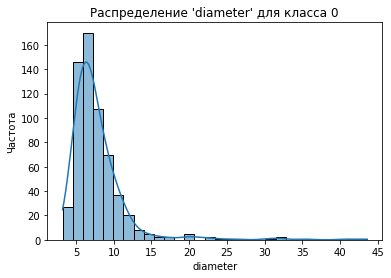

336
18.494382136981425


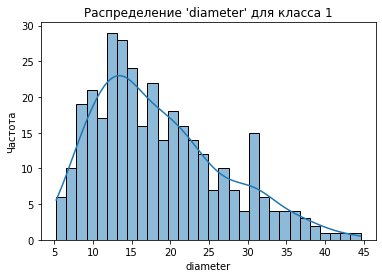

507
8.72604275366372


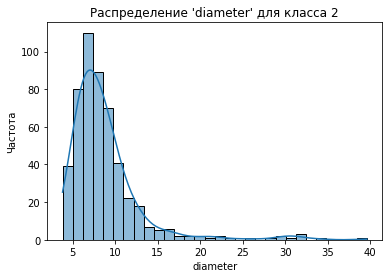

In [20]:
feature = 'diameter'
target = 'malignancy'

classes = table_data[target].unique()

for cls in sorted(classes):
    subset = table_data[table_data[target] == cls]
    print(len(subset))
    print(subset['diameter'].mean())
    plt.figure()
    sns.histplot(subset[feature], kde=True, bins=30)
    plt.title(f"Распределение '{feature}' для класса {cls}")
    plt.xlabel(feature)
    plt.ylabel("Частота")
    plt.show()


609
59.44117647058823


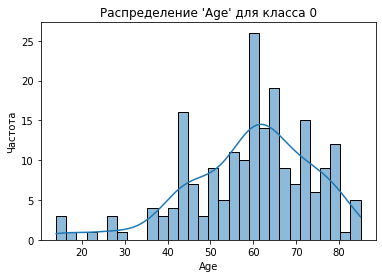

336
60.22222222222222


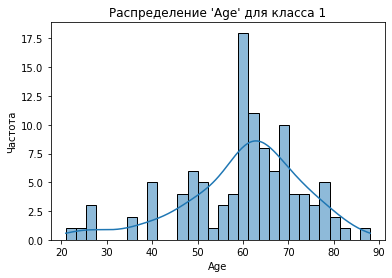

507
59.109375


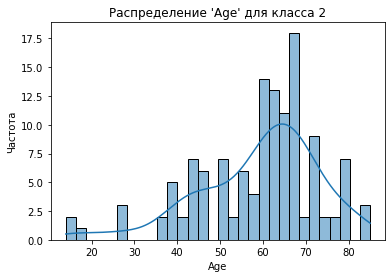

In [21]:
feature = 'Age'
target = 'malignancy'

classes = table_data[target].unique()

for cls in sorted(classes):
    subset = table_data[table_data[target] == cls]
    print(len(subset))
    print(subset[feature].mean())
    plt.figure()
    sns.histplot(subset[feature], kde=True, bins=30)
    plt.title(f"Распределение '{feature}' для класса {cls}")
    plt.xlabel(feature)
    plt.ylabel("Частота")
    plt.show()

609
3.435960591133005


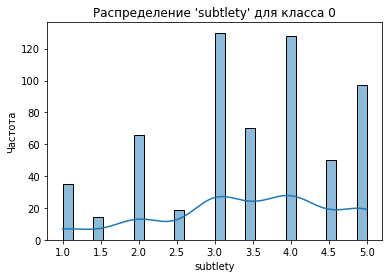

336
4.520833333333333


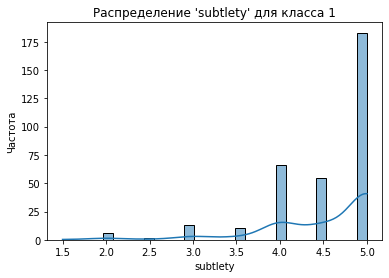

507
3.3826429980276136


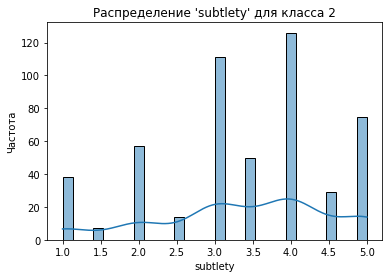

In [22]:
feature = 'subtlety'
target = 'malignancy'

classes = table_data[target].unique()

for cls in sorted(classes):
    subset = table_data[table_data[target] == cls]
    print(len(subset))
    print(subset[feature].mean())
    plt.figure()
    sns.histplot(subset[feature], kde=True, bins=30)
    plt.title(f"Распределение '{feature}' для класса {cls}")
    plt.xlabel(feature)
    plt.ylabel("Частота")
    plt.show()

In [30]:
table_data = table_data[(table_data['num_radiologists'] >=3) | (table_data['diagnosis_type'] == 1)]
print(len(table_data))

842


255
8.478195708880206


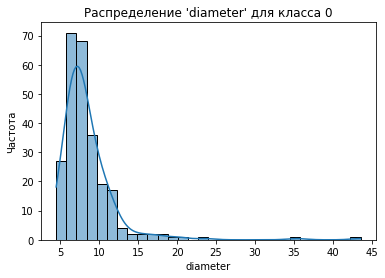

283
18.932282649381992


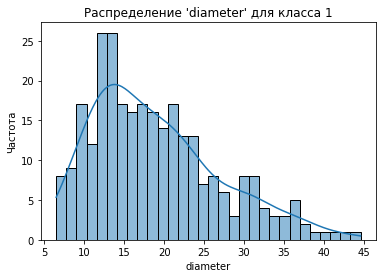

304
9.46442895988732


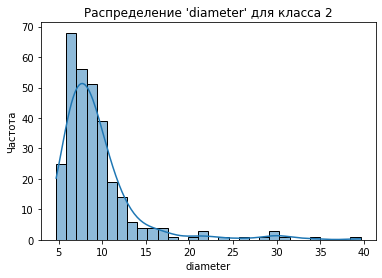

In [22]:
feature = 'diameter'
target = 'malignancy'

classes = table_data[target].unique()

for cls in sorted(classes):
    subset = table_data[table_data[target] == cls]
    print(len(subset))
    print(subset['diameter'].mean())
    plt.figure()
    sns.histplot(subset[feature], kde=True, bins=30)
    plt.title(f"Распределение '{feature}' для класса {cls}")
    plt.xlabel(feature)
    plt.ylabel("Частота")
    plt.show()

255
58.18478260869565


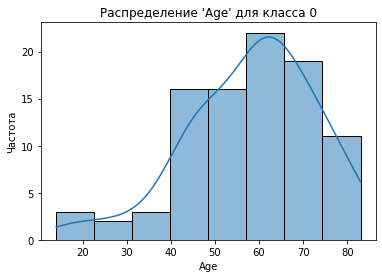

283
59.77


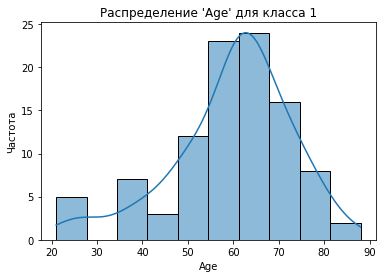

304
60.13414634146341


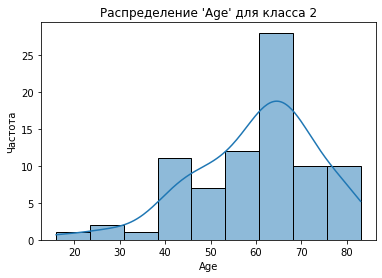

In [27]:
feature = 'Age'
target = 'malignancy'

classes = table_data[target].unique()

for cls in sorted(classes):
    subset = table_data[table_data[target] == cls]
    print(len(subset))
    print(subset[feature].mean())
    plt.figure()
    sns.histplot(subset[feature], kde=True)
    plt.title(f"Распределение '{feature}' для класса {cls}")
    plt.xlabel(feature)
    plt.ylabel("Частота")
    plt.show()

255
3.8705882352941177


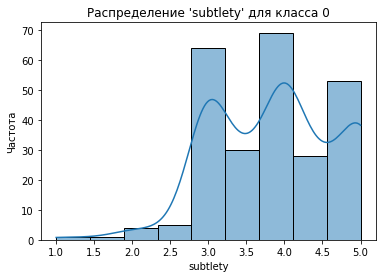

283
4.630742049469965


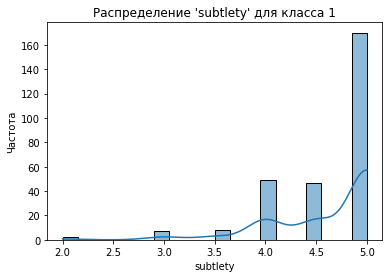

304
3.508223684210526


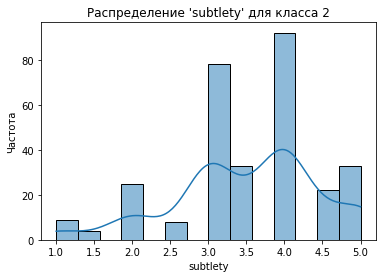

In [28]:
feature = 'subtlety'
target = 'malignancy'

classes = table_data[target].unique()

for cls in sorted(classes):
    subset = table_data[table_data[target] == cls]
    print(len(subset))
    print(subset[feature].mean())
    plt.figure()
    sns.histplot(subset[feature], kde=True)
    plt.title(f"Распределение '{feature}' для класса {cls}")
    plt.xlabel(feature)
    plt.ylabel("Частота")
    plt.show()

In [31]:
table_data.head()

,PatientID,Age,Sex,EthnicGroup,PregnancyStatus,Contrast,NoduleID,diameter,subtlety,internalStructure,calcification,sphericity,margin,texture,malignancy,diagnosis_type,split,num_radiologists
0,LIDC-IDRI-0078,64.0,F,white-ns,4.0,True,0,24.150378,4.5,1,6,4.0,3.5,5.0,1,0,train,4
1,LIDC-IDRI-0078,64.0,F,white-ns,4.0,True,1,20.865896,5.0,1,6,4.0,2.5,4.5,1,0,train,4
3,LIDC-IDRI-0078,64.0,F,white-ns,4.0,True,3,27.333200,5.0,1,4,4.0,3.0,5.0,1,0,train,4
4,LIDC-IDRI-0069,51.0,M,white-ns,4.0,True,0,11.542154,2.5,1,6,4.5,4.5,5.0,2,0,train,4
6,LIDC-IDRI-0069,51.0,M,white-ns,4.0,True,2,24.323491,5.0,1,6,4.0,3.0,5.0,1,0,train,4


In [32]:
len(table_data[table_data['diagnosis_type']==1])

28

In [33]:
table_data.isna().sum()

PatientID              0
Age                  568
Sex                  515
EthnicGroup          799
PregnancyStatus      784
Contrast               0
NoduleID               0
diameter               0
subtlety               0
internalStructure      0
calcification          0
sphericity             0
margin                 0
texture                0
malignancy             0
diagnosis_type         0
split                  0
num_radiologists       0
dtype: int64

In [34]:
table_data.drop(columns=['PatientID', 'NoduleID', 'diagnosis_type', 'num_radiologists', 'EthnicGroup', 'PregnancyStatus'], inplace=True)

In [35]:
table_data = pd.get_dummies(table_data, columns=['Contrast', 'internalStructure', 'calcification'], drop_first=True)

In [36]:
table_data['Sex'] = table_data['Sex'].map({'M': 1, 'F': 0})

In [37]:
table_data.head()

,Age,Sex,diameter,subtlety,sphericity,margin,texture,malignancy,split,Contrast_True,internalStructure_4,calcification_2,calcification_3,calcification_4,calcification_5,calcification_6
0,64.0,0.0,24.150378,4.5,4.0,3.5,5.0,1,train,1,0,0,0,0,0,1
1,64.0,0.0,20.865896,5.0,4.0,2.5,4.5,1,train,1,0,0,0,0,0,1
3,64.0,0.0,27.333200,5.0,4.0,3.0,5.0,1,train,1,0,0,0,1,0,0
4,51.0,1.0,11.542154,2.5,4.5,4.5,5.0,2,train,1,0,0,0,0,0,1
6,51.0,1.0,24.323491,5.0,4.0,3.0,5.0,1,train,1,0,0,0,0,0,1


In [38]:
sample=table_data[table_data['split']=='train']
print(len(sample))
sample=sample[sample['malignancy']<=1]
print(len(sample))

605
393


In [39]:
sample.mean()

C:\Users\Алекхаил\AppData\Local\Temp\ipykernel_22204\642784991.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sample.mean()


Age                    59.250000
Sex                     0.575949
diameter               14.068543
subtlety                4.284987
sphericity              3.806616
margin                  4.202290
texture                 4.768448
malignancy              0.531807
Contrast_True           0.600509
internalStructure_4     0.000000
calcification_2         0.000000
calcification_3         0.170483
calcification_4         0.002545
calcification_5         0.002545
calcification_6         0.824427
dtype: float64

In [40]:
sample.std()

C:\Users\Алекхаил\AppData\Local\Temp\ipykernel_22204\1487051019.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sample.std()


Age                    13.195882
Sex                     0.495769
diameter                8.103526
subtlety                0.786658
sphericity              0.745399
margin                  0.834780
texture                 0.754964
malignancy              0.499623
Contrast_True           0.490418
internalStructure_4     0.000000
calcification_2         0.000000
calcification_3         0.376536
calcification_4         0.050443
calcification_5         0.050443
calcification_6         0.380941
dtype: float64

In [41]:
sample=table_data[table_data['split']=='val']
print(len(sample))

113


In [42]:
sample.mean()

C:\Users\Алекхаил\AppData\Local\Temp\ipykernel_22204\642784991.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sample.mean()


Age                    57.548387
Sex                     0.421053
diameter               13.004001
subtlety                4.039823
sphericity              3.827434
margin                  4.097345
texture                 4.628319
malignancy              1.097345
Contrast_True           0.522124
internalStructure_4     0.000000
calcification_2         0.017699
calcification_3         0.106195
calcification_4         0.008850
calcification_5         0.017699
calcification_6         0.849558
dtype: float64

In [43]:
sample.std()

C:\Users\Алекхаил\AppData\Local\Temp\ipykernel_22204\1487051019.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sample.std()


Age                    14.238068
Sex                     0.500355
diameter                8.499299
subtlety                0.930969
sphericity              0.841899
margin                  1.028301
texture                 1.001737
malignancy              0.812454
Contrast_True           0.501735
internalStructure_4     0.000000
calcification_2         0.132443
calcification_3         0.309459
calcification_4         0.094072
calcification_5         0.132443
calcification_6         0.359097
dtype: float64

In [46]:
print('Доля malignancy=0', len(sample[sample['malignancy']==0])/len(sample))
print('Доля malignancy=1', len(sample[sample['malignancy']==1])/len(sample))
print('Доля malignancy=2',  len(sample[sample['malignancy']==2])/len(sample))

Доля malignancy=0 0.2831858407079646
Доля malignancy=1 0.336283185840708
Доля malignancy=2 0.3805309734513274


In [47]:
sample=table_data[table_data['split']=='test']
print(len(sample))

124


In [48]:
sample.mean()

C:\Users\Алекхаил\AppData\Local\Temp\ipykernel_22204\642784991.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sample.mean()


Age                    63.071429
Sex                     0.500000
diameter               11.051139
subtlety                3.911290
sphericity              3.870968
margin                  4.133065
texture                 4.600806
malignancy              1.080645
Contrast_True           0.475806
internalStructure_4     0.000000
calcification_2         0.000000
calcification_3         0.064516
calcification_4         0.008065
calcification_5         0.000000
calcification_6         0.927419
dtype: float64

In [49]:
sample.std()

C:\Users\Алекхаил\AppData\Local\Temp\ipykernel_22204\1487051019.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sample.std()


Age                    15.064727
Sex                     0.505291
diameter                6.084694
subtlety                0.841138
sphericity              0.692207
margin                  0.872127
texture                 0.892561
malignancy              0.841956
Contrast_True           0.501440
internalStructure_4     0.000000
calcification_2         0.000000
calcification_3         0.246667
calcification_4         0.089803
calcification_5         0.000000
calcification_6         0.260499
dtype: float64

In [50]:
print('Доля malignancy=0', len(sample[sample['malignancy']==0])/len(sample))
print('Доля malignancy=1', len(sample[sample['malignancy']==1])/len(sample))
print('Доля malignancy=2',  len(sample[sample['malignancy']==2])/len(sample))

Доля malignancy=0 0.31451612903225806
Доля malignancy=1 0.2903225806451613
Доля malignancy=2 0.3951612903225806


In [11]:
table_data = table_data[(table_data['malignancy'] <=1)]
print(len(table_data))

538


In [12]:
table_data.head()

,PatientID,Age,Sex,EthnicGroup,PregnancyStatus,Contrast,NoduleID,diameter,subtlety,internalStructure,calcification,sphericity,margin,texture,malignancy,diagnosis_type,split,num_radiologists
0,LIDC-IDRI-0078,64.0,F,white-ns,4.0,True,0,24.150378,4.5,1,6,4.0,3.5,5.0,1,0,train,4
1,LIDC-IDRI-0078,64.0,F,white-ns,4.0,True,1,20.865896,5.0,1,6,4.0,2.5,4.5,1,0,train,4
3,LIDC-IDRI-0078,64.0,F,white-ns,4.0,True,3,27.333200,5.0,1,4,4.0,3.0,5.0,1,0,train,4
6,LIDC-IDRI-0069,51.0,M,white-ns,4.0,True,2,24.323491,5.0,1,6,4.0,3.0,5.0,1,0,train,4
15,LIDC-IDRI-0132,59.0,M,white-ns,4.0,False,3,26.329831,5.0,1,6,4.0,3.5,5.0,1,0,train,4


In [15]:
mal_0=len(table_data[(table_data['malignancy'] ==0)])
mal_1=len(table_data[(table_data['malignancy'] ==1)])
print(mal_0)
print(mal_1)
print(f'Доля доброкачествнных узлов - {mal_0/(mal_0+mal_1)}')
print(f'Доля злокачественных узлов - {mal_1/(mal_0+mal_1)}')

255
283
Доля доброкачествнных узлов - 0.4739776951672863
Доля злокачественных узлов - 0.5260223048327137


In [42]:
table_data.isna().sum()

PatientID              0
Age                  346
Sex                  321
EthnicGroup          513
PregnancyStatus      500
Contrast               0
NoduleID               0
diameter               0
subtlety               0
internalStructure      0
calcification          0
sphericity             0
margin                 0
texture                0
malignancy             0
diagnosis_type         0
split                  0
num_radiologists       0
dtype: int64

In [43]:
table_data.drop(columns=['PatientID', 'NoduleID', 'diagnosis_type', 'num_radiologists', 'EthnicGroup',
                         'PregnancyStatus', 'Age', 'Sex'], inplace=True)

In [45]:
table_data = pd.get_dummies(table_data, columns=['Contrast', 'internalStructure', 'calcification'], drop_first=True)

In [46]:
table_data.head()

,diameter,subtlety,sphericity,margin,texture,malignancy,split,Contrast_True,calcification_3,calcification_4,calcification_5,calcification_6
0,24.150378,4.5,4.0,3.5,5.0,1,train,1,0,0,0,1
1,20.865896,5.0,4.0,2.5,4.5,1,train,1,0,0,0,1
3,27.333200,5.0,4.0,3.0,5.0,1,train,1,0,1,0,0
6,24.323491,5.0,4.0,3.0,5.0,1,train,1,0,0,0,1
15,26.329831,5.0,4.0,3.5,5.0,1,train,0,0,0,0,1


In [47]:
train = table_data[(table_data['split']=='train')]
val = table_data[(table_data['split']=='val')]
test = table_data[(table_data['split']=='test')]
print(len(train))
print(len(val))
print(len(test))

393
70
75


In [48]:
y_train=train['malignancy']
X_train=train.drop(columns=['split', 'malignancy'])
y_val=val['malignancy']
X_val=val.drop(columns=['split', 'malignancy'])
y_test=test['malignancy']
X_test=test.drop(columns=['split', 'malignancy'])
print(len(y_train), len(X_train))
print(len(y_val), len(X_val))
print(len(y_test), len(X_test))

393 393
70 70
75 75


In [50]:
import sklearn
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score



def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)
    score = roc_auc_score(y_val, clf.predict_proba(X_val)[:, 1])
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)

print("Лучшие параметры:", study.best_params)
print("Лучший accuracy:", study.best_value)


[I 2025-04-15 20:16:14,034] A new study created in memory with name: no-name-effed197-6568-45d1-aa91-dc6b95438b0f
[I 2025-04-15 20:16:14,610] Trial 0 finished with value: 0.946546052631579 and parameters: {'n_estimators': 295, 'max_depth': 10, 'min_samples_split': 17, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.946546052631579.
[I 2025-04-15 20:16:14,770] Trial 1 finished with value: 0.946546052631579 and parameters: {'n_estimators': 74, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.946546052631579.
[I 2025-04-15 20:16:15,135] Trial 2 finished with value: 0.9383223684210527 and parameters: {'n_estimators': 168, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.946546052631579.
[I 2025-04-15 20:16:15,547] Trial 3 finished with value: 0.9440789473684211 and parameters: {'n_estimators': 215, 'max_depth': 18, 'min_sa

[I 2025-04-15 20:16:26,193] Trial 32 finished with value: 0.9481907894736842 and parameters: {'n_estimators': 116, 'max_depth': 6, 'min_samples_split': 16, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 23 with value: 0.9506578947368421.
[I 2025-04-15 20:16:26,481] Trial 33 finished with value: 0.9481907894736843 and parameters: {'n_estimators': 146, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 23 with value: 0.9506578947368421.
[I 2025-04-15 20:16:26,767] Trial 34 finished with value: 0.9473684210526316 and parameters: {'n_estimators': 148, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 19, 'max_features': 'log2'}. Best is trial 23 with value: 0.9506578947368421.
[I 2025-04-15 20:16:27,130] Trial 35 finished with value: 0.9366776315789473 and parameters: {'n_estimators': 183, 'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 11, 'max_features': 'log2'}. Best is trial 23 with value: 0.95

[I 2025-04-15 20:16:33,963] Trial 65 finished with value: 0.946546052631579 and parameters: {'n_estimators': 75, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 57 with value: 0.9539473684210527.
[I 2025-04-15 20:16:34,169] Trial 66 finished with value: 0.9457236842105263 and parameters: {'n_estimators': 80, 'max_depth': 21, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 57 with value: 0.9539473684210527.
[I 2025-04-15 20:16:34,344] Trial 67 finished with value: 0.953125 and parameters: {'n_estimators': 60, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 57 with value: 0.9539473684210527.
[I 2025-04-15 20:16:34,505] Trial 68 finished with value: 0.9523026315789473 and parameters: {'n_estimators': 56, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 57 with value: 0.9539473684210527.
[I

[I 2025-04-15 20:16:40,225] Trial 98 finished with value: 0.9161184210526316 and parameters: {'n_estimators': 54, 'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 95 with value: 0.9564144736842106.
[I 2025-04-15 20:16:40,416] Trial 99 finished with value: 0.9547697368421053 and parameters: {'n_estimators': 64, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 95 with value: 0.9564144736842106.
[I 2025-04-15 20:16:40,605] Trial 100 finished with value: 0.9523026315789473 and parameters: {'n_estimators': 66, 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 95 with value: 0.9564144736842106.
[I 2025-04-15 20:16:40,780] Trial 101 finished with value: 0.9547697368421053 and parameters: {'n_estimators': 60, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 95 with value: 0.956414

[I 2025-04-15 20:16:46,330] Trial 131 finished with value: 0.955592105263158 and parameters: {'n_estimators': 51, 'max_depth': 11, 'min_samples_split': 12, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 105 with value: 0.9572368421052633.
[I 2025-04-15 20:16:46,488] Trial 132 finished with value: 0.9539473684210527 and parameters: {'n_estimators': 50, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 105 with value: 0.9572368421052633.
[I 2025-04-15 20:16:46,646] Trial 133 finished with value: 0.953125 and parameters: {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 105 with value: 0.9572368421052633.
[I 2025-04-15 20:16:46,822] Trial 134 finished with value: 0.949013157894737 and parameters: {'n_estimators': 59, 'max_depth': 10, 'min_samples_split': 12, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 105 with value: 0.957236842

Лучшие параметры: {'n_estimators': 53, 'max_depth': 11, 'min_samples_split': 13, 'min_samples_leaf': 4, 'max_features': 'sqrt'}
Лучший accuracy: 0.9572368421052633


In [53]:
from sklearn.metrics import accuracy_score
clf = RandomForestClassifier(
        n_estimators=study.best_params['n_estimators'],
        max_depth=study.best_params['max_depth'],
        min_samples_split=study.best_params['min_samples_split'],
        min_samples_leaf=study.best_params['min_samples_leaf'],
        max_features=study.best_params['max_features'],
        random_state=42,
        n_jobs=-1
    )
clf.fit(X_train, y_train)
print(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print(accuracy_score(y_test, clf.predict_proba(X_test)[:, 1]>0.5))

0.9301994301994302
0.9066666666666666


In [54]:
importances = clf.feature_importances_

feature_names = X_train.columns  

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

           feature  importance
0         diameter    0.518988
1         subtlety    0.208118
9  calcification_6    0.092492
6  calcification_3    0.090177
3           margin    0.044840
2       sphericity    0.022571
5    Contrast_True    0.011558
4          texture    0.011257
7  calcification_4    0.000000
8  calcification_5    0.000000
